In [1]:
using IndexedGraphs, SparseArrays, MatrixProductBP, Random, Plots, Statistics
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

# OBC

## MonteCarlo

In [13]:
include("wolff.jl");

In [463]:
N = 40
T = N - 1
T1 = T + 1
d = (N, T1)
β = 0.5
J0 = 1.0
h0 = 1e-1

# h = sparse([fill(h0, prod(d)÷2); fill(-h0, prod(d)÷2)])
h = sparse(h0*randn(prod(d)))
# h = sparse(fill(h0, prod(d)))
# h = (1:N*T1) ./ (N*T1)
J = J0 * lattice(d, (true, true))

# delete bonds between spins (N,2N), (2N,3N) and so on, because they correspond to interaction xᵢ^ᵀ,xⱼ^ᵀ in
#  the dynamical model, which are not supported
bonds_to_delete = [(N*(T1-1)+i,N*(T1-1)+i+1) for i in 1:N-1]
for b in bonds_to_delete
   J[b...] = J[reverse(b)...] = 0 
end
dropzeros!(J);

In [464]:
ntherm = 10^4
nsamples = 10^6

stats = Stats(N*T1)

wolff(β*J, β*h, nsamples, stats; ntherm);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:45


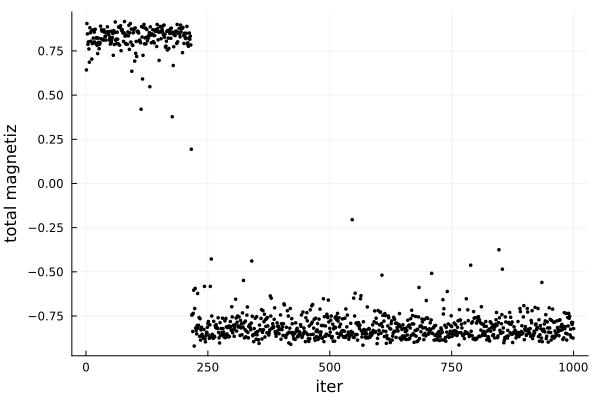

In [465]:
scatter(magnetization(stats)[1:div(end, 1000):end], xlabel="iter", ylabel="total magnetiz", label="",
    ms=2, c=:black, msc=:auto)

In [466]:
# @show mean(m_mc)
# heatmap(reshape(m_mc, N, T1), clims=(-1,1), xlabel="t", ylabel="i", yflip=true)

## MPBP

In [467]:
struct Ising2DOpen{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x

function (f::Ising2DOpen)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + (f.border ? 0 : f.βJh*spin(xₙᵢᵗ[1])) )
    exp(h)
end

In [468]:
βJ = β * J0
# T = N - 1
G = IndexedBiDiGraph(chain(N, true))
h_matrix = reshape(h, N, T1)

w = [[Ising2DOpen(βJ, βJ, i==1) for t=0:T] for i=1:N]
ϕ = [[[exp(β*h_matrix[i,t]), exp(-β*h_matrix[i,t])] for t in 1:T+1] for i in 1:N]
bp = mpbp(G, w, fill(2,N), T; ϕ);

In [469]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [470]:
svd_trunc = TruncBondThresh(8, 1e-8)
iters, cb = iterate!(bp, maxiter=80; svd_trunc, cb, tol=1e-5, damp=0.2);

Running MPBP: iter 38 	 Time: 0:03:37
  Δ:                  0.0
  SVD tolerance, m':  1.0e-8, 8

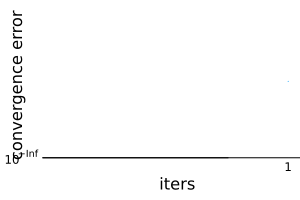

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 38 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/esM5q/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 38 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/esM5q/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: I

In [471]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [472]:
# plot(histogram(m_mc, nbins=8), histogram(reduce(vcat, means(spin, bp)), nbins=8))

In [473]:
# i'm calling `ij` correlations between neighboring variables at the same time step and `tt1`
#  autocorr of variable i with itself at subsequent time steps. These two correspond to horizontal and
#  vertical bonds in the 2d lattice
m_mc = magnetizations(stats)
c_mc_full = correlations(stats)
li = LinearIndices(zeros(N, T1))
c_mc_ij = map(e for e in edges(bp.g) if src(e)<dst(e)) do e
    i,j = e
   map(1:T) do t
        c_mc_full[li[i,t], li[j,t]]
    end
end
c_mc_tt1 = map(1:N) do i
   map(1:T) do t
       c_mc_full[li[i,t], li[i,t+1]] 
    end
end;
c_mc = vcat(reduce(vcat, c_mc_ij), reduce(vcat, c_mc_tt1));

In [474]:
m_bp = permutedims(reduce(hcat, means(spin, bp)))[:]
p_bp = pair_beliefs(bp)[1]
c_bp_ij = map(e for e in edges(bp.g) if src(e)<dst(e)) do e
    pij = p_bp[idx(e)]
    [expectation(spin, pijt) for pijt in pij[1:end-1]]
end
ac_bp = autocorrelations(spin, bp)
c_bp_tt1 = map(ac_bp) do ai
    diag(ai, 1)
end

c_bp = vcat(reduce(vcat, c_bp_ij), reduce(vcat, c_bp_tt1));

Pearson, magnetizations r=0.9997196793657481
Pearson, correlations r=0.9999352040540144


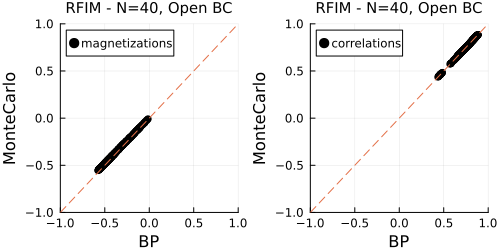

In [475]:
p1 = scatter(m_bp, m_mc, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(m_bp, m_mc)
println("Pearson, magnetizations r=$r")
plot!(title="RFIM - N=$N, Open BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

p2 = scatter(c_bp, c_mc, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="correlations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(c_bp, c_mc)
println("Pearson, correlations r=$r")
plot!(title="RFIM - N=$N, Open BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

plot(p1, p2, size=(500,250))

# OBC in 1 direction (mixed BCs)

## MonteCarlo

In [476]:
N = 40
T = N-1
T1 = T + 1
d = (N, T1)
β = 0.5
J0 = 1.0
h0 = 1e-1

# h = sparse([fill(h0, prod(d)÷2); fill(-h0, prod(d)÷2)])
# h = sparse(h0*randn(prod(d)))
# h = sparse(fill(h0, prod(d)))
# h = (1:N*T1) ./ (N*T1) .- 0.5

hh = h0*randn(T1)
h = reduce(hcat, fill(hh, N))'[:]

J = J0 * lattice(d, (false, true))

# delete bonds between spins (N,2N), (2N,3N) and so on, because they correspond to interaction xᵢ^ᵀ,xⱼ^ᵀ in
#  the dynamical model, which are not supported
bonds_to_delete = [(N*(T1-1)+i,N*(T1-1)+mod(i,N)+1) for i in 1:N]
for b in bonds_to_delete
   J[b...] = J[reverse(b)...] = 0 
end
dropzeros!(J);

In [477]:
ntherm = 10^4
nsamples = 10^5

stats = Stats(N*T1)

wolff(β*J, β*h, nsamples, stats; ntherm);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


In [478]:
# scatter(magnetization(stats)[1:100:end], xlabel="iter", ylabel="total magnetiz", label="",
#     ms=2, c=:black, msc=:auto, size=(300,200))

## MPBP
MPBP on a closed path graph

In [479]:
struct Ising2DPeriodic{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x

function (f::Ising2DPeriodic)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + f.βJh*spin(xₙᵢᵗ[f.border ? 2 : 1]) )
    exp(h)
end

In [480]:
βJ = β * J0
# T = N - 1
G = IndexedBiDiGraph(chain(N, false))
h_matrix = reshape(h, N, T1)

w = [[Ising2DPeriodic(βJ, βJ, i == N || i == 1) for t=0:T] for i=1:N]
ϕ = [[[exp(β*h_matrix[i,t]), exp(-β*h_matrix[i,t])] for t in 1:T+1] for i in 1:N]
bp = mpbp(G, w, fill(2,N), T; ϕ);

In [481]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [482]:
svd_trunc = TruncBondThresh(8, 1e-8)
maxiter = 100
iters, cb = iterate!(bp; maxiter, svd_trunc, cb, tol=1e-4, damp=0.2)
iters == maxiter && @warn "BP did not converge";

Running MPBP: iter 30 	 Time: 0:02:57
  Δ:                  9.007305636754559e-5
  SVD tolerance, m':  1.0e-8, 8

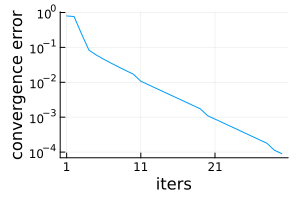

In [483]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [484]:
# plot( histogram(m_mc, nbins=8, normalize=true), 
#       histogram(reduce(vcat, means(spin, bp)), nbins=8, normalize=true) )
# # heatmap(abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N)))
# # abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N))

In [485]:
m_mc = magnetizations(stats)
c_mc_full = correlations(stats)
li = LinearIndices(zeros(N, T1))
c_mc_ij = map(e for e in edges(bp.g) if src(e)<dst(e)) do e
    i,j = e
   map(1:T) do t
        c_mc_full[li[i,t], li[j,t]]
    end
end
c_mc_tt1 = map(1:N) do i
   map(1:T) do t
       c_mc_full[li[i,t], li[i,t+1]] 
    end
end
            
c_mc = vcat(reduce(vcat, c_mc_ij), reduce(vcat, c_mc_tt1));

In [486]:
m_bp = permutedims(reduce(hcat, means(spin, bp)))[:]
p_bp = pair_beliefs(bp)[1]
c_bp_ij = map(e for e in edges(bp.g) if src(e)<dst(e)) do e
    pij = p_bp[idx(e)]
    [expectation(spin, pijt) for pijt in pij[1:end-1]]
end
ac_bp = autocorrelations(spin, bp)
c_bp_tt1 = map(ac_bp) do ai
    diag(ai, 1)
end

c_bp = vcat(reduce(vcat, c_bp_ij), reduce(vcat, c_bp_tt1));

Pearson, magnetizations r=0.9998644283305803
Pearson, correlations r=0.9994463414888103


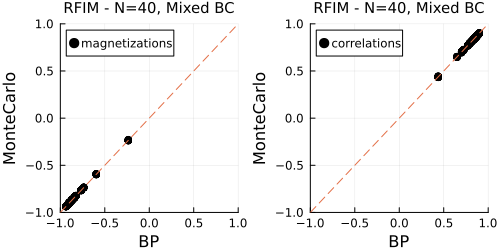

In [487]:
p1 = scatter(m_bp, m_mc, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(m_bp, m_mc)
println("Pearson, magnetizations r=$r")
plot!(title="RFIM - N=$N, Mixed BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

p2 = scatter(c_bp, c_mc, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="correlations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(c_bp, c_mc)
println("Pearson, correlations r=$r")
plot!(title="RFIM - N=$N, Mixed BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

plot(p1, p2, size=(500,250))

## MPBP infinite
MPBP on infinite closed path graph

In [488]:
struct Ising2DInfinite{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
end

spin(x, i = 0) = 3-2x

function (f::Ising2DInfinite)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + 0.5*f.βJh*sum(spin, xₙᵢᵗ) )
    exp(h)
end

In [489]:
G = IndexedBiDiGraph(chain(N, false))
h_matrix = reshape(h, N, T1)

wᵢ = [Ising2DInfinite(β*J0, β*J0) for _ in 1:T+1]
ϕᵢ = [[exp(β*ht), exp(-β*ht)] for ht in hh]

bp_inf = mpbp_infinite_graph(2, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp_inf; f=spin, showprogress=false);

In [490]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp_inf; f=spin);

In [491]:
svd_trunc = TruncBondThresh(2, 1e-8)
maxiter = 100
iters, cb = iterate!(bp_inf; maxiter, svd_trunc, cb, tol=1e-5, damp=0.2)
iters == maxiter && @warn "BP did not converge";

Running MPBP: iter 41 	 Time: 0:00:02
  Δ:                  8.567057411368317e-6
  SVD tolerance, m':  1.0e-8, 2

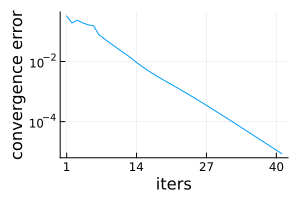

In [492]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [493]:
m_bp_inf = only(means(spin, bp_inf))
c_mc_inf = vcat(mean(c_mc_ij), mean(c_mc_tt1));

In [494]:
p_bp = pair_beliefs(bp_inf)[1]
c_bp_inf_ij = map(Iterators.drop(edges(bp_inf.g),1)) do e
    pij = p_bp[idx(e)]
    [expectation(spin, pijt) for pijt in pij[1:end-1]]
end
ac_bp_inf = autocorrelations(spin, bp_inf)
c_bp_inf_tt1 = map(ac_bp_inf) do ai
    diag(ai, 1)
end

c_bp_inf = vcat(reduce(vcat, c_bp_inf_ij), reduce(vcat, c_bp_inf_tt1));

Pearson, magnetizations r=0.9998644283305803
Pearson, correlations r=0.999946263189938


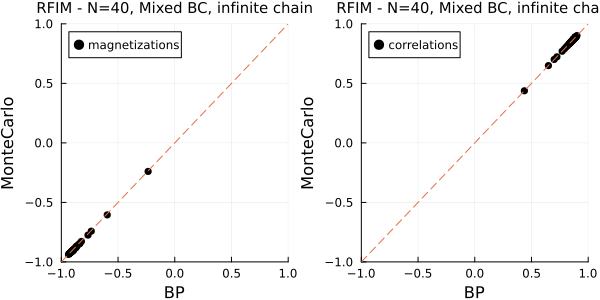

In [495]:
p1 = scatter(mean(eachrow(reshape(m_mc, N, T1))), m_bp_inf, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc)
println("Pearson, magnetizations r=$r")
plot!(title="RFIM - N=$N, Mixed BC, infinite chain", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

p2 = scatter(c_bp_inf, c_mc_inf, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="correlations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(c_bp_inf, c_mc_inf)
println("Pearson, correlations r=$r")
plot!(title="RFIM - N=$N, Mixed BC, infinite chain", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

plot(p1, p2, size=(600,300))